# EEE485 Statistical Learning and Data Analytics Project
    Multilayered Perceptron 
    Ayhan Okuyan
In this section, we will implement a generic multilayered perceptron structure that uses bakvpropagation to update the weights in the layers. We will be constructing two separate classes, one being the layer class and the other one being the network class that takes advantage of the layer instances in a list. 

For the loss functions, we will be implemeting Mean Squared Error loss and Cross-Entropy loss (with Softmax Output Layer Activation). 

\begin{equation}
Loss_{MSE}(y_i,\hat{y_i})=\sum_{c=1}^P (y_{i,c}-\hat{y}_{i,c})^2
\end{equation}

\begin{equation}
Loss_{CE}(y_i,\hat{y_i})=\sum_{c=1}^N I(y_{i,c}=1)log(\hat{y}_{i,c})
\end{equation}

For the hidden layers, we will be implementing several activaiton functions given as ReLU, Sigmoid, SoftMax and tanh activations.

\begin{equation}
\phi_{ReLU}(x)=
\begin{cases}
0 &\ \text{  if  } x<0 \\
x &\ \text{  if  } x>=0 
\end{cases}
\end{equation}

\begin{equation}
\phi_{SoftMax}(x)= \frac{e^{x_i}}{\sum{_k} e^{x_k}}
\end{equation}

\begin{equation}
\phi_{sigmoid}(x)= \sigma(x)= \frac{1}{1+e^x} = \frac{e^x}{1+e^x}
\end{equation}

\begin{equation}
\phi_{tanh}(x) = tanh(x) = 2\sigma(2x)-1
\end{equation}

In [1]:
import matplotlib.pyplot as plt
import numpy as np

## Layer Class
This class represents one of the fully connected layers that is in the network architecture.
The input parameters for the constructor are given as:
- **inputDim:** number of connections from the input or the previous layer.
- **numNeurons:** number of neurons in the layer.
- **activation:** activation function for the neurons in the layer. <br>{'softmax', 'relu', 'tanh', 'sigmoid'}
- **std:** standard deviation of the initial weight matrix.
- **mean:** expectation of the initial weight matrix, default is 0.

The initial weights are taken from the Gaussian distribution
\begin{equation}
w_i \in \mathcal{W}, w_i \sim \mathcal{N}(\mu, \sigma^2), \forall{i}
\end{equation}

### Activations
The activation functions are as given in the beginning. The forward pass of the layer is as given below. Where n denotes the batch size, number of input samples inputted to the layer , and p respresents the number of features, meaning the number of neurons in the layers
\begin{equation}
W_{(p,1)}, \: X{(n,p)} \\
W_E = 
\begin{bmatrix}
W  \\
\theta
\end{bmatrix}_{(p+1,1)}
\end{equation}

\begin{equation}
\tilde{X}=
\begin{bmatrix}
X & -1
\end{bmatrix}_{(n,p+1)} 
\end{equation} \\
\begin{equation}
\hat{Y} = \phi(\tilde{X}W_E)
\end{equation}

### Derivatives 
In order to be able to backpropagate, we need to obtain the derivatives of the activation functions. In the original local gradients algorithm, the derivatives are taken for the outputs that are not passed through the activation. However, the activation functions that we use are special funcitons in the sense that their derivatives can be written in terms of themselves. Hence, we only keep the values of the outputs of the layers and describe the derivatives accordingly.

\begin{equation}
\phi_{ReLU}'(v)=
\begin{cases}
0 &\ \text{  if  } v<0 \\
1 &\ \text{  if  } v>=0 
\end{cases} \Rightarrow
\begin{cases}
0 &\ \text{  if  } y<0 \\
1 &\ \text{  if  } y>=0 
\end{cases}
\end{equation}

\begin{equation}
\phi_{sigmoid}'(v)= \sigma(v)(1-\sigma(v)) \Rightarrow y(1-y)
\end{equation}

\begin{equation}
\phi_{tanh}'(v) = 1-tanh^2(v) \Rightarrow 1-y^2
\end{equation}

This part doesn't include the softmax derivative since that is only used in combination with cross-entropy loss due to the compuational efficiency, which will be explained during the implementation of loss functions.

In [2]:
class Layer:
    def __init__(self, inputDim, numNeurons, activation, std, mean=0):
        self.inputDim = inputDim
        self.numNeurons = numNeurons
        self.activation = activation
            
        self.weights = np.random.normal(mean,std, inputDim*numNeurons).reshape(numNeurons, inputDim)
        self.biases = np.random.normal(mean,std, numNeurons).reshape(numNeurons,1)
        self.weightsE = np.concatenate((self.weights, self.biases), axis=1)
            
        self.delta = None
        self.error = None
        self.lastActiv = None        
        
    def actFcn(self,x):
        if(self.activation == 'sigmoid'):
            expx = np.exp(x)
            return expx/(1+expx)
        elif(self.activation == 'softmax'):
            expx = np.exp(x - np.max(x))
            return expx/np.sum(expx, axis=0)
        elif(self.activation == 'tanh'):
            return np.tanh(x)
        elif(self.activation == 'relu'):
            out = np.maximum(0,x)
            return out
                    
    def activate(self, x):
        if self.activation == 'sigmoid' or self.activation == 'softmax' or self.activation == 'relu':
            if(x.ndim == 1):
                x = x.reshape(x.shape[0],1)
            numSamples = x.shape[1]
            tempInp = np.r_[x, [np.ones(numSamples)*1]]
            self.lastActiv = self.actFcn(np.matmul(self.weightsE, tempInp))
        return self.lastActiv
    
    def derActiv(self, x):
        if(self.activation == 'sigmoid'):
            return x*(1-x)
        elif(self.activation == 'softmax'):
            return x*(1-x)
        elif(self.activation == 'tanh'):
            return 1 - x**2;
        elif(self.activation == 'relu'):
            der = x
            der[x > 0] = 1
            der[x <= 0] = 0
            return der
    
    def __repr__(self):
        return "Input Dim: " + str(self.inputDim) + ", Number of Neurons: " + str(self.numNeurons) + "\n Activation: " + self.activation

## MLP Class

This class represents the fully-connected layer structure. The layers list hold the consecutive layer objects.
Forward class simply forwards the data sequemtially from the input to the output bu using each of their respective activation functions. 

### Backpropagation

The backptopagaiton algorithm uses the local gradients algorithm to iterate backwards through the layers in order to learn the weights of the algorithm as given below. 
If the current layer is the output layer, the errors and gradients differ in the sense that the derivatives of the ouytput functions are involved in the algorithm, hence if the loss is Mean Squared Error, then

\begin{equation}
e_{output} = \hat{y_{output}} - y_{output} \\
\delta_{output} = \phi'(v_{output}) \odot e_{output}
\end{equation}

Furthermore, if the loss is defined as the Cross-Entropy Error and the output activation is Softmax, then the delta of the output layer becomes,

\begin{equation}
\delta_{output} = y_{output} - \hat{y}_{output}
\end{equation}

For the hidden layers, the delta and errors of the respectful layers become as follows.

\begin{equation}
e_{hidden,t} = W_{t+1}\delta_{t+1} \\
\delta_{hidden,t} = \phi'(v_{hidden,t}) \odot e_{hidden,t}
\end{equation}

where, t resprents the index of the layer in a sequential manner. Hence, after all the error and deltas are found, the updates are calculated as follows in a Gradient Descent setting. We will be using the stochastic mini-batch gradient descent algorithm as stated in the Phase 1 report. 

\begin{equation}
W_{E,t+1} = W_{E,t} + \eta \delta_{t} \tilde{X}_{layer,t}
\end{equation}

where X represents the input matrix of that respective layer and "t" represents time instance, if not the input layer, the input becomes the output of the previous layer with an addition of a 1 row. However, we will be using a constant momentum coefficent in the implementation since the gradients oscillate too much when approaching the minima. Hence, the updated update rule becomes as given below.

\begin{equation}
\Delta W_{E,t} = \eta \delta_{t} \tilde{X}_{layer,t} + \alpha \Delta W_{E,t-1} \\
W_{E,t+1} = W_{E,t} + \Delta W_{E,t}
\end{equation}

In [3]:
class MLP:
    def __init__(self):
        self.layers = []
        
    def addLayer(self, layer):
        self.layers.append(layer)
        
    def forward(self, inp):
        out = inp
        for lyr in self.layers:
            out = lyr.activate(out)
        return out
    
    def prediction(self, inp):
        out = self.forward(inp)
        if(out.ndim == 1):
            return np.argmax(out)
        return np.argmax(out, axis=0) 
    
    def topKaccuracy(self, inp, realOut, k):
        out = self.forward(inp)
        cnt = 0
        for i in range(out.shape[1]):
            topKind = (out[:,i]).argsort()[::-1][:k]
            if realOut[i] in topKind:
                cnt += 1
        return cnt/out.shape[1]
    
    def backProp(self, inp, out, lrnRate, batchSize, loss):
        net_out = self.forward(inp)
        for i in reversed(range(len(self.layers))):
            lyr = self.layers[i]
            #outputLayer
            if(lyr == self.layers[-1]):
                if(loss == 'mse'):
                    lyr.error = net_out -out
                    derMatrix = lyr.derActiv(lyr.lastActiv)
                    lyr.delta = derMatrix * lyr.error
                elif(loss == 'ce' and lyr.activation == 'softmax'):
                    lyr.delta = net_out - out
                else:
                    assert('Cant do that')
            #hiddenLayer
            else:
                nextLyr = self.layers[i+1]
                nextLyr.weights = nextLyr.weightsE[:,0:nextLyr.weights.shape[1]]
                lyr.error = np.matmul(nextLyr.weights.T, nextLyr.delta)
                derMatrix = lyr.derActiv(lyr.lastActiv)
                lyr.delta = derMatrix * lyr.error
        
        #update weights
        for i in range(len(self.layers)):
            lyr = self.layers[i]
            if(i == 0):
                if(inp.ndim == 1):
                    inp = inp.reshape(inp.shape[0],1)
                numSamples = inp.shape[1]
                inputToUse = inputToUse = np.r_[inp, [np.ones(numSamples)*1]]
            else:
                numSamples = self.layers[i - 1].lastActiv.shape[1]
                inputToUse = np.r_[self.layers[i - 1].lastActiv, [np.ones(numSamples)*1]]
                
            update =  (lrnRate * np.matmul(lyr.delta, inputToUse.T))/batchSize
            lyr.weightsE -= update
            
    def train(self, inp, out, inpTest, outTest, lrnRate, epochNum, batchSize, loss):
        errList = []
        trAccs = []
        valAccs = []
        valKAccs = []
        
        for ep in range(epochNum):
            print('--------------------------------------------------------------\nEpoch', ep+1)
            
            randomIndexes = np.random.permutation(len(inp))
            inp = inp[randomIndexes]
            out = out[randomIndexes]
            numBatches = int(np.floor(len(inp)/batchSize))
            
            for j in range(numBatches):
                batch_inp = inp[batchSize*j:batchSize*j+batchSize]
                batch_out = out[batchSize*j:batchSize*j+batchSize]
                
                batch_out_1H = mat1H2(batch_out, np.max(out)+1).T
                
                self.backProp(batch_inp.T, batch_out_1H, lrnRate, batchSize, loss)
            
            valOutput = self.forward(inpTest.T)
            if(loss == 'ce'):
                err = - np.sum(np.log(valOutput) * mat1H2(outTest, np.max(out)+1).T)/valOutput.shape[1]
            elif(loss == 'mse'):
                err = np.sum((outTest.T - self.forward(inpTest.T))**2)/valOutput.shape[1]
            print(loss.upper() +' Validation Error ', err)
            errList.append(err)
            
            trPred = self.prediction(inp.T)
            trAcc = np.sum(trPred.reshape((trPred.shape[0],1)) == out)/trPred.shape[0]*100
            print('Training Accuracy: ', trAcc)
            trAccs.append(trAcc)
            
            valPred = self.prediction(inpTest.T)
            valAcc = np.sum(valPred.reshape((valPred.shape[0],1)) == outTest)/valPred.shape[0]*100
            print('Validation Accuracy: ', valAcc)
            valAccs.append(valAcc)
            
            #k is chosen as three
            K = 3
            topKacc = self.topKaccuracy(inpTest.T, outTest, K)*100
            print('Top ' + str(K) + ' Accuracy: ', topKacc)
            valKAccs.append(topKacc)
            
          
        return errList, trAccs, valAccs, valKAccs
    
    def __repr__(self):
        retStr = ""
        for i, lyr in enumerate(self.layers):
            retStr += "Layer " + str(i) + ": " + lyr.__repr__() + "\n"
        return retStr

After building the network structure, we load the data we have preprocessed in the Data Analysis section.

In [4]:
features = np.load('dataMLP.npy', allow_pickle=True)
labels = np.load('labelsMLP.npy', allow_pickle=True)
print(features, features.shape)
print(labels, labels.shape)

[[0.65     0.083    0.724    ... 0.135    0.465984 0.693   ]
 [0.63     0.323    0.685    ... 0.0439   0.257536 0.323   ]
 [0.62     0.0675   0.762    ... 0.0959   0.180188 0.0862  ]
 ...
 [0.47     0.901    0.517    ... 0.148    0.21654  0.813   ]
 [0.44     0.262    0.745    ... 0.146    0.280124 0.489   ]
 [0.35     0.0973   0.758    ... 0.0287   0.335588 0.479   ]] (190440, 11)
[14 14 14 ... 10 10 10] (190440,)


In [5]:
labels = labels.reshape((labels.shape[0],1))
print(labels, labels.shape)

[[14]
 [14]
 [14]
 ...
 [10]
 [10]
 [10]] (190440, 1)


In [6]:
def PCA(eigenvalues, eigenvectors, k):
    #argsort the eigenvalues in descending order
    eigvals_ind = np.argsort(eigenvalues)[::-1]
    #sort the eigenvalues and eigenvectors accordingly
    eigenvalues = eigenvalues[eigvals_ind]
    eigenvectors = eigenvectors[:,eigvals_ind]
    #select k biggest eigenvectors
    eigfcs = eigenvectors[:,:k]
    #get the transpose of the eigenmatrix
    eigfcs = eigfcs.T
    return eigfcs

def reconstruct(data_mn, eigfcs, mean):
    #data==D, eigenfaces==E
    #reconstructed_data = (D*E')*E + mean
    proj = np.matmul(data_mn,eigfcs.T)
    proj = np.matmul(proj,eigfcs) + mean
    return proj

Percent Explained Variances
PEV for k=1  33.74422246797036
PEV for k=2  49.47216405564261
PEV for k=3  59.68917062161931
PEV for k=4  68.56672808155403
PEV for k=5  76.17548067064581
PEV for k=6  83.11402035438327
PEV for k=7  88.72886010179718
PEV for k=8  93.15117698788197
PEV for k=9  96.52404748805709
PEV for k=10  98.97334408995677
PEV for k=11  99.99999999999999


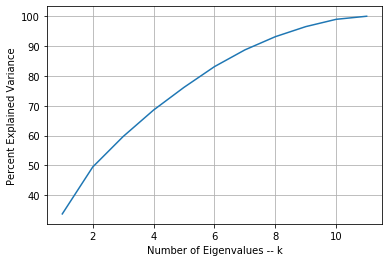

In [7]:
mean = np.mean(features, axis=0)
data_mn = features - mean
data_mn /= np.std(data_mn, axis=0)

cov_mat = np.matmul(data_mn.T,data_mn)
eigenvalues, eigenvectors = np.linalg.eigh(cov_mat)

#explained variances
#argsort the eigenvalues in descending order
eigvals_ind = np.argsort(eigenvalues)[::-1]
#sort the eigenvalues and eigenvectors accordingly
eigenvalues = eigenvalues[eigvals_ind]
eigenvectors = eigenvectors[:,eigvals_ind]
k_vals = np.array([1,2,3,4,5,6,7,8,9,10,11])
tot_var = np.sum(eigenvalues)
vas = np.zeros(k_vals.shape[0])
for ind in range(k_vals.shape[0]):
    vas[ind] = np.sum(eigenvalues[:k_vals[ind]]/tot_var*100.0)
print("Percent Explained Variances")
for i in range(vas.shape[0]):
    print("PEV for k=" + str(k_vals[i]) + " ", vas[i])
plt.plot(k_vals,vas)
plt.xlabel("Number of Eigenvalues -- k")
plt.ylabel("Percent Explained Variance")
plt.grid()
plt.show()

In [8]:
k = 8
pcs = PCA(eigenvalues,eigenvectors,k)
ext_features = reconstruct(data_mn,pcs,mean)
print(ext_features.shape)

(190440, 11)


Then, we split the data as stated in the Phase 1 report as a Three-Way Split since we have a lot of data instances, we do not need to use cross validation for this algorithm at the very least.

In [9]:
#three-way split
def splitData(X, y, tr, val):
    np.random.seed(456)
    shuffle = np.random.permutation(len(y))
    X = X[shuffle]
    y = y[shuffle]
    
    tr_ind = int(np.floor(len(y)*tr))
    val_ind = int(np.floor(len(y)*(tr+val)))
    
    X_tr = X[0:tr_ind]
    y_tr = y[0:tr_ind]
    X_val = X[tr_ind:val_ind]
    y_val = y[tr_ind:val_ind]
    X_test = X[val_ind:]
    y_test = y[val_ind:]
    
    return X_tr, y_tr, X_val, y_val, X_test, y_test

In [10]:
def vector1H(x, maxInd): 
    out = np.zeros(maxInd)
    out[x] = 1 
    return out 
def mat1H2(y, maxInd): 
    out = np.zeros((y.shape[0], maxInd))
    for i in range(y.shape[0]): 
        out[i,:] = vector1H(y[i], maxInd)
    return out

The split that will be used is an 70%,20%,10% split. 


In [11]:
x_train, y_train, x_val, y_val, x_test, y_test = splitData(ext_features, labels, 0.7, 0.2)

Before, training with the designed architecture, we use state-of-the-art tensorflow.keras to train the same network for comparsion purposes.

In [12]:
from tensorflow.keras import layers, models, initializers, optimizers
model = models.Sequential()
model.add(layers.Dense(500, input_shape=(11,), activation='relu',\
                       kernel_initializer=initializers.VarianceScaling(mode='fan_out', \
                                                                       distribution = 'normal', \
                                                                       seed=None, \
                                                                       scale=2.0),\
                        bias_initializer = initializers.VarianceScaling(mode='fan_out', \
                                                                       distribution = 'normal', \
                                                                       seed=None, \
                                                                       scale=2.0))) 
model.add(layers.Dense(300,activation='relu',\
                       kernel_initializer=initializers.VarianceScaling(mode='fan_out', \
                                                                       distribution = 'normal', \
                                                                       seed=None, \
                                                                       scale=2.0),\
                       bias_initializer = initializers.VarianceScaling(mode='fan_out', \
                                                                       distribution = 'normal', \
                                                                       seed=None, \
                                                                       scale=2.0))) 
model.add(layers.Dense(150,activation='relu',\
                       kernel_initializer=initializers.VarianceScaling(mode='fan_out', \
                                                                       distribution = 'normal', \
                                                                       seed=None, \
                                                                       scale=2.0),\
                       bias_initializer = initializers.VarianceScaling(mode='fan_out', \
                                                                       distribution = 'normal', \
                                                                       seed=None, \
                                                                       scale=2.0))) 
model.add(layers.Dense(65,activation='relu',\
                       kernel_initializer=initializers.VarianceScaling(mode='fan_out', \
                                                                       distribution = 'normal', \
                                                                       seed=None, \
                                                                       scale=2.0),\
                       bias_initializer = initializers.VarianceScaling(mode='fan_out', \
                                                                       distribution = 'normal', \
                                                                       seed=None, \
                                                                       scale=2.0))) 
model.add(layers.Dense(np.max(labels)+1, activation='softmax',\
                       kernel_initializer=initializers.VarianceScaling(mode='fan_out',\
                                                                       distribution = 'normal',\
                                                                       seed=None,\
                                                                       scale=2.0),\
                       bias_initializer = initializers.VarianceScaling(mode='fan_out', \
                                                                       distribution = 'normal', \
                                                                       seed=None, \
                                                                       scale=2.0))) 
momOp = optimizers.SGD(lr=0.1, momentum=0, nesterov=False, decay=0)
model.compile(loss='sparse_categorical_crossentropy', optimizer=momOp, metrics=['accuracy'])
hist = model.fit(x_train,y_train, epochs=25, validation_data=(x_val,y_val), batch_size=529)

Train on 133308 samples, validate on 38087 samples
Epoch 1/25
133308/133308 [==============================] - 1s 11us/sample - loss: 2.0159 - accuracy: 0.3524 - val_loss: 1.8317 - val_accuracy: 0.3899
Epoch 2/25
133308/133308 [==============================] - 1s 5us/sample - loss: 1.8173 - accuracy: 0.3936 - val_loss: 1.8151 - val_accuracy: 0.3904
Epoch 3/25
133308/133308 [==============================] - 1s 6us/sample - loss: 1.7789 - accuracy: 0.4045 - val_loss: 1.7735 - val_accuracy: 0.4016
Epoch 4/25
133308/133308 [==============================] - 1s 5us/sample - loss: 1.7553 - accuracy: 0.4123 - val_loss: 1.7625 - val_accuracy: 0.4050
Epoch 5/25
133308/133308 [==============================] - 1s 5us/sample - loss: 1.7394 - accuracy: 0.4165 - val_loss: 1.7363 - val_accuracy: 0.4161
Epoch 6/25
133308/133308 [==============================] - 1s 5us/sample - loss: 1.7290 - accuracy: 0.4175 - val_loss: 1.7398 - val_accuracy: 0.4130
Epoch 7/25
133308/133308 [======================

For the initializition of the weights, for the network with ReLU activations, we will be using the Kaiming initialization given as,

\begin{equation}
w_{l,i} \in \mathcal{W_l}, w_{l,i} \sim \mathcal{N}(0, \sqrt{2/n_l}), \forall{i=1,...,n_l}
\end{equation}

where, $\mathcal{l}$ denotes the layer and $\mathcal{n}$  represents the number of neurons in that layer.

In [13]:
#Final Version
mlp = MLP()
mlp.addLayer(Layer(x_train.shape[1], 500, 'relu', np.sqrt(2/500)))
mlp.addLayer(Layer(500, 300, 'relu', np.sqrt(2/300)))
mlp.addLayer(Layer(300, 150, 'relu', np.sqrt(2/150)))
mlp.addLayer(Layer(150, 65, 'relu', np.sqrt(2/65)))
mlp.addLayer(Layer(65, np.max(labels)+1, 'softmax',\
                   np.sqrt(2/(np.max(labels)+1))))

ceErrs, trAccs, valAccs, valKAccs = mlp.train(x_train, y_train, x_val, y_val, 0.1, 25, 529, loss='ce')

--------------------------------------------------------------
Epoch 1
CE Validation Error  1.8890523325202948
Training Accuracy:  38.032226122963365
Validation Accuracy:  37.96833565258487
Top 3 Accuracy:  66.24044949720377
--------------------------------------------------------------
Epoch 2
CE Validation Error  1.8003132528056385
Training Accuracy:  40.53770216341105
Validation Accuracy:  40.19481712920419
Top 3 Accuracy:  69.01567463964082
--------------------------------------------------------------
Epoch 3
CE Validation Error  1.8129012782700407
Training Accuracy:  39.91583400846161
Validation Accuracy:  39.283745109880016
Top 3 Accuracy:  68.47480767716019
--------------------------------------------------------------
Epoch 4
CE Validation Error  1.7888218065433426
Training Accuracy:  40.76424520658925
Validation Accuracy:  39.90600467351065
Top 3 Accuracy:  69.34124504424082
--------------------------------------------------------------
Epoch 5
CE Validation Error  1.76080171

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


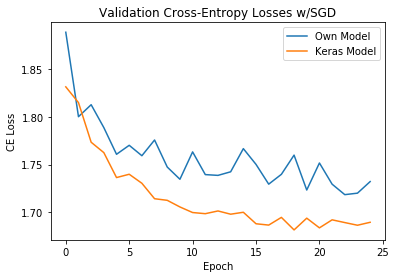

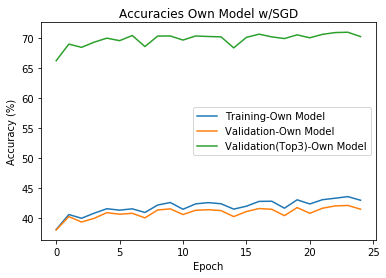

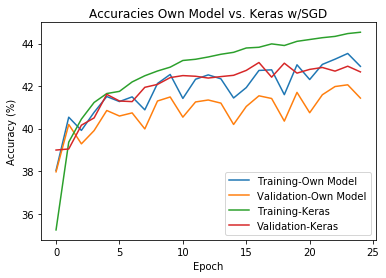

In [14]:
print(hist.history.keys())
plt.plot(ceErrs)
plt.plot(hist.history['val_loss'])
plt.title('Validation Cross-Entropy Losses w/SGD')
plt.xlabel('Epoch')
plt.ylabel('CE Loss')
plt.legend(['Own Model', 'Keras Model'])
plt.show()

plt.plot(trAccs)
plt.plot(valAccs)
plt.plot(valKAccs)
plt.title('Accuracies Own Model w/SGD')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend(['Training-Own Model', 'Validation-Own Model', 'Validation(Top3)-Own Model'])
plt.show()

plt.plot(trAccs)
plt.plot(valAccs)
plt.plot(np.asarray(hist.history['accuracy'])*100)
plt.plot(np.asarray(hist.history['val_accuracy'])*100)
plt.title('Accuracies Own Model vs. Keras w/SGD')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend(['Training-Own Model', 'Validation-Own Model', 'Training-Keras', 'Validation-Keras'])
plt.show()

In [15]:
np.save('valAcc_SGD_pca.npy', valAccs)

In [16]:
testPred = mlp.prediction(x_test.T)
testAcc = np.sum(testPred.reshape((testPred.shape[0],1)) == y_test)/testPred.shape[0]*100
print(testAcc)

41.50170648464164
